# **Regression (Second Attempt)**

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import zipfile

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score ,mean_absolute_error, mean_squared_error,  max_error, explained_variance_score
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
# Opening zipfile and reading it to a dataframe
with zipfile.ZipFile('wine_reviews_clean.zip', 'r') as zipf:
    zipf.extractall('')

df = pd.read_csv('wine_reviews_clean.csv')

os.remove('wine_reviews_clean.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421017 entries, 0 to 421016
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Name                421017 non-null  object 
 1   Variety             421017 non-null  object 
 2   Country             421017 non-null  object 
 3   Region              386109 non-null  object 
 4   Zone                253609 non-null  object 
 5   Attr_1              417986 non-null  object 
 6   Attr_2              76720 non-null   object 
 7   Winemaker_notes     95234 non-null   object 
 8   Review              93840 non-null   object 
 9   Alcohol_percentage  420952 non-null  float64
 10  Alcohol_vol         420952 non-null  float64
 11  Avg_rating          45970 non-null   float64
 12  N_ratings           45970 non-null   float64
 13  Price_Feature       419607 non-null  float64
 14  Year                418078 non-null  float64
dtypes: float64(6), object(9)
memory us

,Name,Variety,Country,Region,Zone,Attr_1,Attr_2,Winemaker_notes,Review,Alcohol_percentage,Alcohol_vol,Avg_rating,N_ratings,Price_Feature,Year
0,M. Chapoutier La Combe Pilate Esteban Brut Nature,Vintage Sparkling Wine,France,Rhone,NaN,Sparkling & Champagne,Green Wine,NaN,NaN,10.0,750.0,5.0,15.0,49.99,2020.0
1,Vinos de Arganza Alvarez de Toledo Godello,Godello,Spain,NaN,NaN,White Wine,NaN,This wine has a bright yellow color with fresh...,NaN,0.0,750.0,5.0,13.0,10.99,2020.0
2,Louis Latour Vosne-Romanee,Pinot Noir,France,Burgundy,Cote d'Or,Red Wine,Boutique,NaN,"Toasty, spicy aromas introduce this rich, silk...",0.0,750.0,5.0,20.0,119.99,2019.0
3,Chateau Bouscaut,Bordeaux Red Blends,France,Bordeaux,Pessac-Leognan,Red Wine,NaN,"Blend: 61% Merlot, 33% Cabernet Sauvignon, 6% ...",This estate continues to produce brilliant win...,14.5,750.0,5.0,17.0,44.99,2020.0
4,Brandini Barolo La Morra,Nebbiolo,Italy,Piedmont,Barolo,Red Wine,Green Wine,"Made with organically farmed fruit, the La Mor...","Aromas of cherries, strawberries and tar with ...",14.0,750.0,5.0,19.0,63.99,2015.0


In [3]:
# Check for outliers
def get_outliers(data, threshold=3):
    z_scores = np.abs(stats.zscore(data, nan_policy='omit'))
    outliers = np.where(z_scores > threshold, np.nan, 0)
    return outliers

outliers = df.select_dtypes('float64').apply(get_outliers, axis=0)

outliers_df = df.join(outliers, rsuffix='_IsOutlier')

outliers_df.iloc[:, -6:].notna().sum()

Alcohol_percentage_IsOutlier    420998
Alcohol_vol_IsOutlier           415141
Avg_rating_IsOutlier            420717
N_ratings_IsOutlier             420362
Price_Feature_IsOutlier         412648
Year_IsOutlier                  418243
dtype: int64

In [4]:
# Eliminate this outliers
clean_df = outliers_df.dropna(subset=outliers_df.columns.tolist()[-6:])
clean_df = clean_df.drop(outliers_df.columns.tolist()[-6:], axis=1)

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405906 entries, 0 to 421016
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Name                405906 non-null  object 
 1   Variety             405906 non-null  object 
 2   Country             405906 non-null  object 
 3   Region              371395 non-null  object 
 4   Zone                241475 non-null  object 
 5   Attr_1              403100 non-null  object 
 6   Attr_2              68063 non-null   object 
 7   Winemaker_notes     89805 non-null   object 
 8   Review              84430 non-null   object 
 9   Alcohol_percentage  405841 non-null  float64
 10  Alcohol_vol         405841 non-null  float64
 11  Avg_rating          44313 non-null   float64
 12  N_ratings           44313 non-null   float64
 13  Price_Feature       405168 non-null  float64
 14  Year                403193 non-null  float64
dtypes: float64(6), object(9)
memory us

In [5]:
# Creating a customer function to compute the different metrics for regression
def regression_report(y_true, y_pred):
    print('Regression Report\n')
    print('r2_score:', r2_score(y_true, y_pred).round(3))
    print('explained_variance_score:', explained_variance_score(y_true, y_pred).round(3))
    print('mean_absolute_error:', mean_absolute_error(y_true, y_pred).round(3))
    print('mean_squared_error:', mean_squared_error(y_true, y_pred).round(3))
    print('max_error:', max_error(y_true, y_pred).round(3))

## *Numerical Variables*

In [6]:
# Selecting data for the experiment
exp1_var = ['Alcohol_percentage', 'Alcohol_vol', 'Avg_rating', 'N_ratings', 'Year', 'Price_Feature']
exp1_df = clean_df[exp1_var].dropna()

# Spliting data into regressor variables and target
X = exp1_df.iloc[:, :-1]
y = exp1_df.iloc[:, -1]

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Creating a preprocessor for the columns
exp1_preprocessor = ColumnTransformer([
    ('Numerical', MinMaxScaler(), X.columns.tolist())
], remainder='passthrough')

# Creating a pipeline
exp1_reg = Pipeline([
    ('preprocessor', exp1_preprocessor),
    ('regressor', LinearRegression())
])

# Training
exp1_reg.fit(X_train, y_train)

# Perform predictions
y_pred = exp1_reg.predict(X_test)

# Custom Regression Report
regression_report(y_test, y_pred)

Regression Report

r2_score: 0.201
explained_variance_score: 0.201
mean_absolute_error: 19.163
mean_squared_error: 953.783
max_error: 253.404


## *Numerical and Categorical Data*

In [7]:
# Selecting data for the experiment
exp2_var = ['Alcohol_percentage', 'Alcohol_vol', 'Avg_rating', 'N_ratings', 
            'Variety', 'Country', 'Region', 'Attr_1', 'Price_Feature']
exp2_var = clean_df[exp2_var].dropna()

# Spliting data into regressor variables and target
X2 = exp2_var.iloc[:, :-1]
y2 = exp2_var.iloc[:, -1]

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.20, random_state=0)

# Creating a preprocessor for the columns
exp2_preprocessor = ColumnTransformer([
    ('Numerical', MinMaxScaler(), X2.select_dtypes('float64').columns.tolist()),
    ('Categorical', OneHotEncoder(handle_unknown='ignore'), X2.select_dtypes('object').columns.tolist())
], remainder='passthrough')

# Creating a pipeline
exp2_reg = Pipeline([
    ('preprocessor', exp2_preprocessor),
    ('regressor', LinearRegression())
])

# Training
exp2_reg.fit(X_train, y_train)

# Perform predictions
y2_pred = exp2_reg.predict(X_test)

# Customer Regression Report
regression_report(y_test, y2_pred)

Regression Report

r2_score: 0.31
explained_variance_score: 0.31
mean_absolute_error: 18.17
mean_squared_error: 887.44
max_error: 245.68


## *Categorical Data*

In [8]:
# Selecting data for the experiment
exp3_var = ['Variety', 'Country', 'Region', 'Attr_1', 'Price_Feature']
exp3_df = clean_df[exp3_var].dropna()

# Spliting data into regressor variables and target
X3 = exp3_df.iloc[:, :-1]
y3 = exp3_df.iloc[:, -1]

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.20, random_state=0)

# Creating a preprocessor for the columns
exp3_preprocessor = ColumnTransformer([
    ('Categorical', OneHotEncoder(handle_unknown='ignore'), X3.select_dtypes('object').columns.tolist())
], remainder='passthrough')

# Creating a pipeline
exp3_reg = Pipeline([
    ('preprocessor', exp3_preprocessor),
    ('regressor', LinearRegression())
])

# Training
exp3_reg.fit(X_train, y_train)

# Perform predictions
y3_pred = exp3_reg.predict(X_test)

# Customer Regression Report
regression_report(y_test, y3_pred)

Regression Report

r2_score: 0.223
explained_variance_score: 0.223
mean_absolute_error: 22.117
mean_squared_error: 1224.267
max_error: 254.581


## *Text Data*

In [9]:
# Selecting data for the experiment
exp4_var = ['Winemaker_notes', 'Review', 'Price_Feature']
exp4_df = clean_df[exp4_var].dropna()

# Spliting data into regressor variables and target
X4 = exp4_df.iloc[:, :-1]
y4 = exp4_df.iloc[:, -1]

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X4, y4, test_size=0.20, random_state=0)

# Creating a preprocessor for the columns
exp4_preprocessor = ColumnTransformer([
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review')
], remainder='passthrough')

# Creating a pipeline
exp4_reg = Pipeline([
    ('preprocessor', exp4_preprocessor),
    ('regressor', LinearRegression())
])

# Training
exp4_reg.fit(X_train, y_train)

# Perform predictions
y4_pred = exp4_reg.predict(X_test)

# Customer Regression Report
regression_report(y_test, y4_pred)

Regression Report

r2_score: 0.45
explained_variance_score: 0.451
mean_absolute_error: 26.842
mean_squared_error: 1356.079
max_error: 228.452


## *Text and Numerical Data*

In [10]:
# Selecting data for the experiment
exp5_var = ['Winemaker_notes', 'Review', 'Alcohol_percentage', 'Alcohol_vol', 'Avg_rating', 'N_ratings',
            'Price_Feature']
exp5_df = clean_df[exp5_var].dropna()

# Spliting data into regressor variables and target
X5 = exp5_df.iloc[:, :-1]
y5 = exp5_df.iloc[:, -1]

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X5, y5, test_size=0.20, random_state=0)

# Creating a preprocessor for the columns
exp5_preprocessor = ColumnTransformer([
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review'),
    ('Numerical', MinMaxScaler(), X5.select_dtypes('float64').columns.tolist())
], remainder='passthrough')

# Creating a pipeline
exp5_reg = Pipeline([
    ('preprocessor', exp5_preprocessor),
    ('regressor', LinearRegression())
])

# Training
exp5_reg.fit(X_train, y_train)

# Perform predictions
y5_pred = exp5_reg.predict(X_test)

# Customer Regression Report
regression_report(y_test, y5_pred)

Regression Report

r2_score: 0.467
explained_variance_score: 0.471
mean_absolute_error: 18.827
mean_squared_error: 759.934
max_error: 222.015


## *Text and Categorical Data*

In [11]:
# Selecting data for the experiment
exp6_var = ['Winemaker_notes', 'Review', 'Variety', 'Country', 'Region', 'Attr_1', 'Price_Feature']
exp6_df = clean_df[exp6_var].dropna()

# Spliting data into regressor variables and target
X6 = exp6_df.iloc[:, :-1]
y6 = exp6_df.iloc[:, -1]

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X6, y6, test_size=0.20, random_state=0)

# Creating a preprocessor for the columns
exp6_preprocessor = ColumnTransformer([
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review'),
    ('Categorical', OneHotEncoder(handle_unknown='ignore'), X6.select_dtypes('object')[2:].columns.tolist())
], remainder='passthrough')

# Creating a pipeline
exp6_reg = Pipeline([
    ('preprocessor', exp6_preprocessor),
    ('regressor', LinearRegression())
])

# Training
exp6_reg.fit(X_train, y_train)

# Perform predictions
y6_pred = exp6_reg.predict(X_test)

# Customer Regression Report
regression_report(y_test, y6_pred)

Regression Report

r2_score: 0.579
explained_variance_score: 0.581
mean_absolute_error: 22.672
mean_squared_error: 1064.937
max_error: 209.542


## *Text, Categorical and Numerical Data*

In [12]:
# Selecting data for the experiment
exp7_var = ['Winemaker_notes', 'Review', 'Variety', 'Country', 'Region', 'Attr_1', 
            'Alcohol_percentage', 'Alcohol_vol', 'Avg_rating', 'N_ratings', 'Price_Feature']
exp7_df = clean_df[exp7_var].dropna()

# Spliting data into regressor variables and target
X7 = exp7_df.iloc[:, :-1]
y7 = exp7_df.iloc[:, -1]

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X7, y7, test_size=0.20, random_state=0)

# Creating a preprocessor for the columns
exp7_preprocessor = ColumnTransformer([
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review'),
    ('Numerical', MinMaxScaler(), X7.select_dtypes('float64').columns.tolist()),
    ('Categorical', OneHotEncoder(handle_unknown='ignore'), X7.select_dtypes('object')[2:].columns.tolist())
], remainder='passthrough')

# Creating a pipeline
exp7_reg = Pipeline([
    ('preprocessor', exp7_preprocessor),
    ('regressor', LinearRegression())
])

# Training
exp7_reg.fit(X_train, y_train)

# Perform predictions
y7_pred = exp7_reg.predict(X_test)

# Customer Regression Report
regression_report(y_test, y7_pred)

Regression Report

r2_score: 0.57
explained_variance_score: 0.574
mean_absolute_error: 16.522
mean_squared_error: 592.06
max_error: 153.042


## *Performing PCA (TruncatedSVD)*

In [92]:
# Selecting data for the experiment
exp8_var = ['Winemaker_notes', 'Review', 'Variety', 'Country', 'Region', 'Attr_1', 
            'Alcohol_percentage', 'Alcohol_vol', 'Avg_rating', 'N_ratings', 'Price_Feature']
exp8_df = clean_df[exp8_var].dropna()

# Spliting data into regressor variables and target
X8 = exp8_df.iloc[:, :-1]
y8 = exp8_df.iloc[:, -1]

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X8, y8, test_size=0.20, random_state=0)

# Creating a preprocessor for the columns
exp8_preprocessor = ColumnTransformer([
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(1,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(1,2)), 'Review'),
    ('Numerical', MinMaxScaler(), X8.select_dtypes('float64').columns.tolist()),
    ('Categorical', OneHotEncoder(handle_unknown='ignore'), X8.select_dtypes('object')[2:].columns.tolist())
], remainder='passthrough')

# Creating a pipeline
exp8_reg = Pipeline([
    ('preprocessor', exp8_preprocessor),
    ('pca', TruncatedSVD(300)),
    ('regressor', LinearRegression())
])

# Training
exp8_reg.fit(X_train, y_train)

# Perform predictions
y8_pred = exp8_reg.predict(X_test)

# Customer Regression Report
regression_report(y_test, y8_pred)

Regression Report

r2_score: 0.467
explained_variance_score: 0.469
mean_absolute_error: 18.043
mean_squared_error: 734.831
max_error: 178.717


## **Testing Different Regressors**

As fas as all the experiments performed go, all the features without PCA is by far the one that adjusts better to the data. Now, we will perform several experiments with the same arrangement of data but with different kinds of regressors in order to find something that can be launch into production.

In [15]:
# Selecting data that will be used
exp_var = ['Winemaker_notes', 'Review', 'Variety', 'Country', 'Region', 'Attr_1',
           'Alcohol_percentage', 'Alcohol_vol', 'Avg_rating', 'N_ratings', 'Price_Feature']
exp_df = clean_df[exp_var].dropna()

# Selecting X and y
X = exp_df.iloc[:, :-1]
y = exp_df.iloc[:, -1]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Creating a preprocessor for the data
preprocessor = ColumnTransformer([
    ('Winemaker_notes', TfidfVectorizer(ngram_range=(2,2)), 'Winemaker_notes'),
    ('Review', TfidfVectorizer(ngram_range=(2,2)), 'Review'),
    ('Numerical', MinMaxScaler(), X.select_dtypes('float64').columns.tolist()),
    ('Categorical', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes('object')[2:].columns.tolist())
], remainder='passthrough')

### *Lasso Regression*

In [18]:
# Importing the model
from sklearn.linear_model import Lasso

# Generating a Pipeline to preprocess, train, and test
lasso_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

# Training
lasso_reg.fit(X_train, y_train)

# Perform predictions
y_pred = lasso_reg.predict(X_test)

# Customer Regression Report
regression_report(y_test, y_pred)

Regression Report

r2_score: 0.237
explained_variance_score: 0.239
mean_absolute_error: 20.773
mean_squared_error: 1051.292
max_error: 213.014


### *Ridge Regression*

In [20]:
from sklearn.linear_model import Ridge

# Generating a Pipeline to preprocess, train, and test
ridge_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Training
ridge_reg.fit(X_train, y_train)

# Perform predictions
y_pred = ridge_reg.predict(X_test)

# Customer Regression Report
regression_report(y_test, y_pred)

Regression Report

r2_score: 0.545
explained_variance_score: 0.546
mean_absolute_error: 16.586
mean_squared_error: 627.464
max_error: 160.512


### *SDG Regressor*

In [21]:
from sklearn.linear_model import SGDRegressor

# Generating a Pipeline to preprocess, train, and test
sdg_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SGDRegressor())
])

# Training
sdg_reg.fit(X_train, y_train)

# Perform predictions
y_pred = sdg_reg.predict(X_test)

# Customer Regression Report
regression_report(y_test, y_pred)

Regression Report

r2_score: 0.524
explained_variance_score: 0.524
mean_absolute_error: 16.818
mean_squared_error: 656.34
max_error: 165.383


### *SVM Regressor*

In [22]:
from sklearn.svm import SVR

# Generating a Pipeline to preprocess, train, and test
svr_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='rbf'))
])

# Training
svr_reg.fit(X_train, y_train)

# Perform predictions
y_pred = svr_reg.predict(X_test)

# Customer Regression Report
regression_report(y_test, y_pred)

Regression Report

r2_score: 0.222
explained_variance_score: 0.274
mean_absolute_error: 17.115
mean_squared_error: 1072.04
max_error: 228.601


### *Random Forest Regressor*

In [23]:
from sklearn.ensemble import RandomForestRegressor

# Generating a Pipeline to preprocess, train, and test
forest_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(max_depth=10))
])

# Training
forest_reg.fit(X_train, y_train)

# Perform predictions
y_pred = forest_reg.predict(X_test)

# Customer Regression Report
regression_report(y_test, y_pred)

Regression Report

r2_score: 0.407
explained_variance_score: 0.407
mean_absolute_error: 17.726
mean_squared_error: 816.982
max_error: 197.121


### *Gradient Boosting Regressor*

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

# Generating a Pipeline to preprocess, train, and test
gradient_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])

# Training
gradient_reg.fit(X_train, y_train)

# Perform predictions
y_pred = gradient_reg.predict(X_test)

# Customer Regression Report
regression_report(y_test, y_pred)

Regression Report

r2_score: 0.449
explained_variance_score: 0.449
mean_absolute_error: 16.857
mean_squared_error: 759.759
max_error: 190.119


### *KNN Regressor*

In [25]:
from sklearn.neighbors import KNeighborsRegressor

# Generating a Pipeline to preprocess, train, and test
knn_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=5))
])

# Training
knn_reg.fit(X_train, y_train)

# Perform predictions
y_pred = knn_reg.predict(X_test)

# Customer Regression Report
regression_report(y_test, y_pred)

Regression Report

r2_score: 0.425
explained_variance_score: 0.425
mean_absolute_error: 16.614
mean_squared_error: 792.602
max_error: 195.4


## **Tuning**

Most of the previous models performed similarly, with Ridge Regression and SDG Regresor being the top performers, still they get similar results to the fast Linear Regression. So, in order to investigate further its performance we can perform a GridSearchCV, which includes fine tuning of the hyperparameters and cross_validation testing.

### *Ridge Regression*

In [28]:
# Create Parameter Grid
ridge_grid = {'regressor__alpha':[0.001, 0.01, 0.1, 1.0, 10.0]}

# Create Grid Search Object
ridge_search = GridSearchCV(ridge_reg, param_grid=ridge_grid, scoring='neg_mean_absolute_error', cv=5)
ridge_search.fit(X, y)

# Getting best parameters and storing the best model
print('Best Hyperparameters:', ridge_search.best_params_)
print('Best Score:', ridge_search.best_score_)

# Extracting the best model
best_ridge_model = ridge_search.best_estimator_

Best Hyperparameters: {'regressor__alpha': 0.01}
Best Score: -18.513743380409768


In [39]:
# Custom regression report
regression_report(y_test, best_ridge_model.predict(X_test))

Regression Report

r2_score: 0.999
explained_variance_score: 0.999
mean_absolute_error: 0.136
mean_squared_error: 1.174
max_error: 35.707


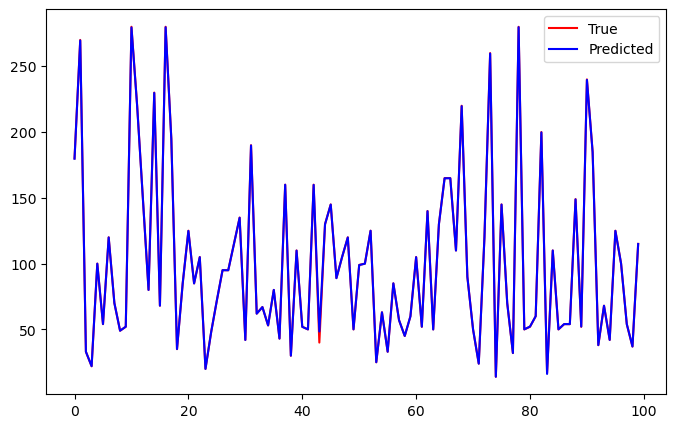

In [46]:
# Plotting results
plt.figure(figsize=(8,5))
plt.plot(range(100), y.iloc[100:200], color='r', label='True')
plt.plot(range(100), best_ridge_model.predict(X.iloc[100:200]), color='b', label='Predicted')
plt.legend()
plt.show()

### *SDG Regressor*

In [35]:
# Create Parameter Grid
sdg_grid = {'regressor__alpha':[0.0001, 0.001, 0.01],
            'regressor__loss':['sqared_loss', 'huber', 'epsilon_insensitive'],
            'regressor__penalty':['l1', 'l2', 'elasticnet']}

# Create Grid Search Object
sdg_search = GridSearchCV(sdg_reg, param_grid=sdg_grid, scoring='neg_mean_absolute_error', cv=5)
sdg_search.fit(X, y)

# Getting best parameters and storing the best model
print('Best Hyperparameters:', sdg_search.best_params_)
print('Best Score:', sdg_search.best_score_)

# Extracting the best model
best_sdg_model = sdg_search.best_estimator_

Best Hyperparameters: {'regressor__alpha': 0.0001, 'regressor__loss': 'epsilon_insensitive', 'regressor__penalty': 'l2'}
Best Score: -19.86929291176615


In [38]:
# Custom regression report
regression_report(y_test, best_sdg_model.predict(X_test))

Regression Report

r2_score: 0.268
explained_variance_score: 0.312
mean_absolute_error: 16.372
mean_squared_error: 1008.01
max_error: 223.897


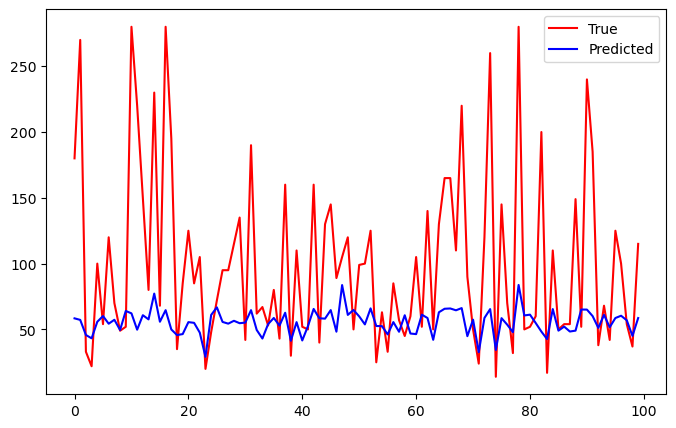

In [47]:
# Plotting results
plt.figure(figsize=(8,5))
plt.plot(range(100), y.iloc[100:200], color='r', label='True')
plt.plot(range(100), best_sdg_model.predict(X.iloc[100:200]), color='b', label='Predicted')
plt.legend()
plt.show()